<a href="https://colab.research.google.com/github/billumillu/Image-Segmentation-fastai-Unet/blob/main/Image_Segmentation_fastai_Unet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
#!pip install nteract-scrapbook

In [4]:
# Ensure edits to libraries are loaded and plotting is shown in the notebook.
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import sys
sys.path.append("../../")
from pathlib import Path
import urllib

import fastai
from fastai.vision import *
import numpy as np
import scrapbook as sb

from utils_cv.common.data import unzip_url
from utils_cv.common.gpu import db_num_workers, which_processor
from utils_cv.segmentation.data import Urls
from utils_cv.segmentation.dataset import read_classes
from utils_cv.segmentation.model import get_ratio_correct_metric, predict, confusion_matrix, print_accuracies
from utils_cv.segmentation.plot import plot_image_and_mask, plot_mask_stats, plot_segmentation, plot_confusion_matrix

print(f"Fast.ai version = {fastai.__version__}")
which_processor()

Fast.ai version = 1.0.61
Torch is using GPU: Tesla T4


In [5]:
# Path to data
DATA_PATH = unzip_url(Urls.fridge_objects_path, exist_ok=True)

# Choose between "high_accuracy" and "fast_inference"
MODEL_TYPE = "fast_inference"

# Training parameters
EPOCHS = 10            # Set to 20 or higher to improve maximum
LEARNING_RATE = 3e-4

# Reject all predictions with confidence lower than this threshold
THRESHOLD = None

#Set parameters based on your selected model.
assert MODEL_TYPE in ["high_accuracy", "fast_inference"]
if MODEL_TYPE == "fast_inference":
    IM_SIZE = [200, 150]
    ARCHITECTURE = models.resnet18
    BATCH_SIZE = 8
    
elif MODEL_TYPE == "high_accuracy":
    IM_SIZE = [500, 375]
    ARCHITECTURE = models.resnet50
    BATCH_SIZE = 2

In [6]:
DATA_PATH = Path(DATA_PATH)
DATA_PATH.ls()

[PosixPath('/content/data/segFridgeObjects/images'),
 PosixPath('/content/data/segFridgeObjects/segmentation-masks'),
 PosixPath('/content/data/segFridgeObjects/classes.txt')]

In [7]:
im_path = DATA_PATH / "images"
im_paths = sorted(get_image_files(im_path))
im_paths[:3]

[PosixPath('/content/data/segFridgeObjects/images/1.jpg'),
 PosixPath('/content/data/segFridgeObjects/images/10.jpg'),
 PosixPath('/content/data/segFridgeObjects/images/100.jpg')]

In [8]:
anno_path = DATA_PATH / "segmentation-masks"
mask_paths = sorted(get_image_files(anno_path))
mask_paths[:3]

[PosixPath('/content/data/segFridgeObjects/segmentation-masks/1.png'),
 PosixPath('/content/data/segFridgeObjects/segmentation-masks/10.png'),
 PosixPath('/content/data/segFridgeObjects/segmentation-masks/100.png')]

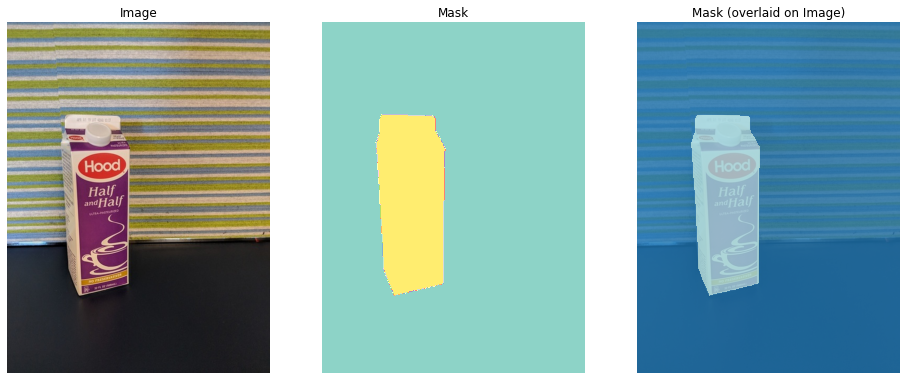

In [9]:
plot_image_and_mask(im_paths[0], mask_paths[0], alpha=0.8)

In [10]:
classes_path = DATA_PATH / "classes.txt"
classes = read_classes(classes_path)
print(classes)

['background', 'can', 'carton', 'milk_bottle', 'water_bottle']


In [11]:
# Define function which, given as input a path to an image, returns the corresponding path to its mask
get_gt_filename = lambda x: anno_path / f"{x.stem}.png"

# Load data
data = (
    SegmentationItemList.from_folder(im_path)
    #.split_by_fname_file('../valid.txt')  #example how to implement a dedicated split 
    .split_by_rand_pct(valid_pct=0.2, seed=10)
    .label_from_func(get_gt_filename, classes=classes)
    .transform(get_transforms(), resize_method = ResizeMethod.CROP, size=IM_SIZE, tfm_y=True)
    .databunch(bs=BATCH_SIZE, num_workers=db_num_workers())
    .normalize(imagenet_stats)
)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample wi

In [12]:
data.batch_stats

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample wi

<bound method ImageDataBunch.batch_stats of ImageDataBunch;

Train: LabelList (103 items)
x: SegmentationItemList
Image (3, 200, 150),Image (3, 200, 150),Image (3, 200, 150),Image (3, 200, 150),Image (3, 200, 150)
y: SegmentationLabelList
ImageSegment (1, 200, 150),ImageSegment (1, 200, 150),ImageSegment (1, 200, 150),ImageSegment (1, 200, 150),ImageSegment (1, 200, 150)
Path: /content/data/segFridgeObjects/images;

Valid: LabelList (25 items)
x: SegmentationItemList
Image (3, 200, 150),Image (3, 200, 150),Image (3, 200, 150),Image (3, 200, 150),Image (3, 200, 150)
y: SegmentationLabelList
ImageSegment (1, 200, 150),ImageSegment (1, 200, 150),ImageSegment (1, 200, 150),ImageSegment (1, 200, 150),ImageSegment (1, 200, 150)
Path: /content/data/segFridgeObjects/images;

Test: None>

In [13]:
print(f"Number of images: {len(data.y.items)}")
print(f"Classes: {data.classes}")

Number of images: 103
Classes: ['background', 'can', 'carton', 'milk_bottle', 'water_bottle']


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample wi

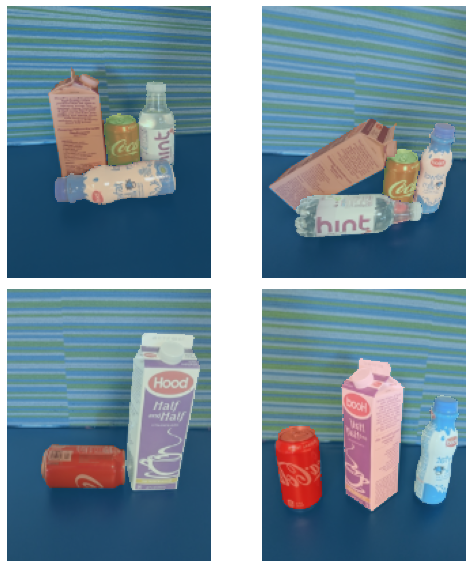

In [14]:
data.show_batch(rows=2)

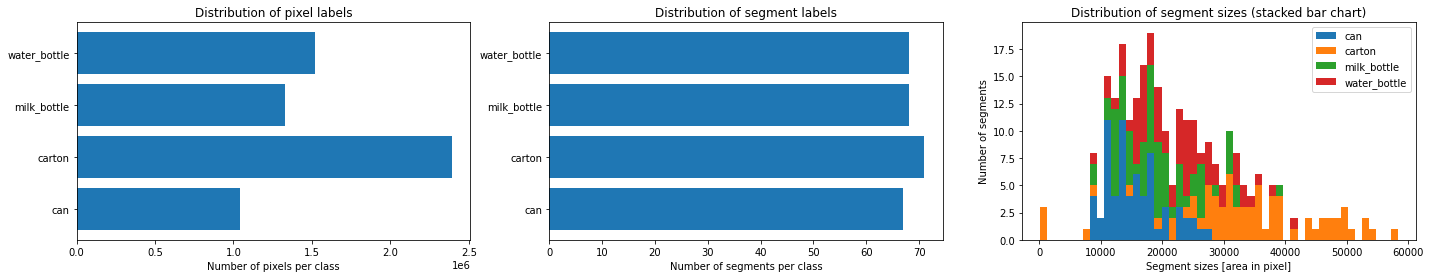

In [15]:
plot_mask_stats(data, classes, figsize=(24,4), exclude_classes = ['background'])

In [16]:
learn = unet_learner(
    data, 
    ARCHITECTURE, 
    wd=1e-2, 
    metrics=get_ratio_correct_metric(classes)
)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "


epoch,train_loss,valid_loss,ratio_correct,time
0,0.792358,0.426227,0.856461,00:10
1,0.574111,0.366096,0.889557,00:07
2,0.428852,0.116276,0.959395,00:07
3,0.322355,0.073547,0.974999,00:07
4,0.243765,0.049251,0.981643,00:07
5,0.189882,0.051358,0.981559,00:07
6,0.151109,0.042402,0.984139,00:07
7,0.122841,0.038212,0.985700,00:07
8,0.101432,0.035765,0.986593,00:07
9,0.085650,0.035509,0.986623,00:07


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample wi

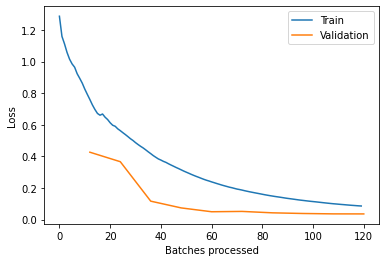

In [17]:
learn.unfreeze()
learn.fit_one_cycle(EPOCHS, LEARNING_RATE) 
learn.recorder.plot_losses()

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample wi

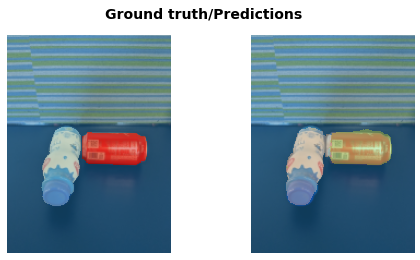

In [18]:
learn.show_results(rows=1)

In [24]:
cmat, cmat_norm = confusion_matrix(learn, data.valid_dl)
accs = print_accuracies(cmat, cmat_norm, classes)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample wi

Overall accuracy: 98.66%
Class-averaged accuracy: 96.02%
	Class      background has accuracy: 99.47%
	Class             can has accuracy: 96.62%
	Class          carton has accuracy: 95.31%
	Class     milk_bottle has accuracy: 95.02%
	Class    water_bottle has accuracy: 93.69%


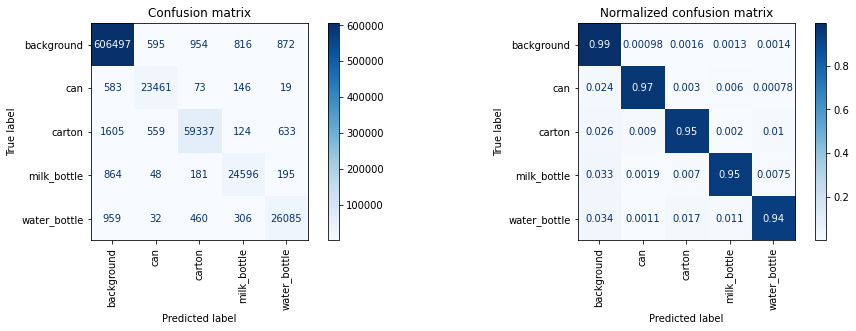

In [20]:
plot_confusion_matrix(cmat, cmat_norm, classes)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "


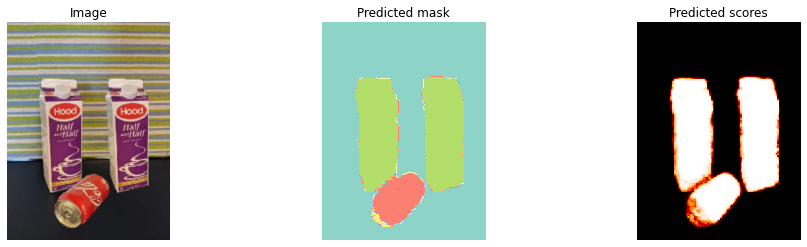

In [21]:
# Download an example image
IM_URL = "https://cvbp.blob.core.windows.net/public/images/cvbp_two_cartons.jpg"
im_path = "example.jpg"
urllib.request.urlretrieve(IM_URL, im_path)

# Run model inference
mask, scores = predict(im_path, learn, thres=0.2)

# Plot results
plot_segmentation(im_path, mask, scores)

In [22]:
for i in range(mask.max()+1):
    print(f"Class {classes[i]:>15} has {sum(sum(mask == i)):>6} pixels")

Class      background has  21258 pixels
Class             can has   1592 pixels
Class          carton has   7059 pixels
Class     milk_bottle has      0 pixels
Class    water_bottle has     91 pixels


In [23]:
# Preserve some of the notebook outputs
sb.glue("validation_overall_accuracy", accs[0])
sb.glue("validation_class_accuracies", list(accs[1]))